In [7]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 200
IMAGE_WIDTH = 320

In [10]:

tfrecords_filename = '/notebooks/Minecraft-AI/mc-data/mesa.tfrecords'

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    label =  tf.cast(features['label'], tf.int32)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, annotations, label

Tensor("Cast_14:0", shape=(), dtype=int32)
(200, 320, 3)
current batch


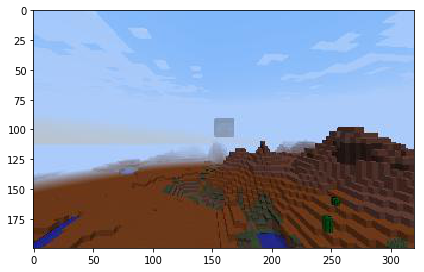

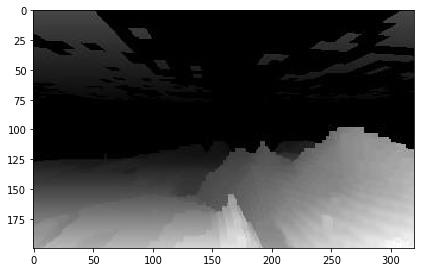

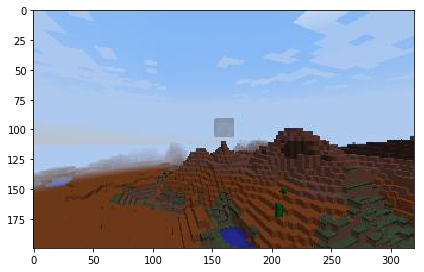

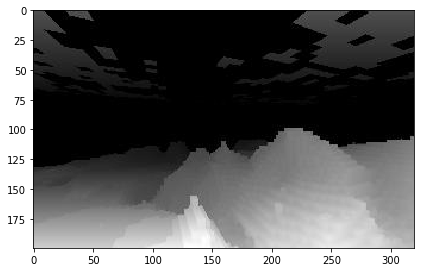

(200, 320, 3)
current batch


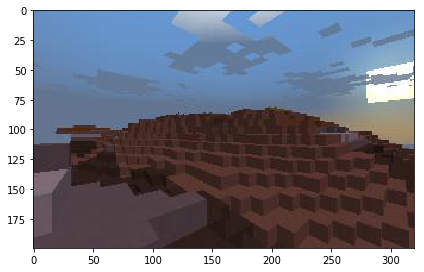

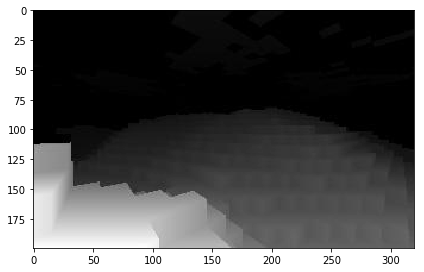

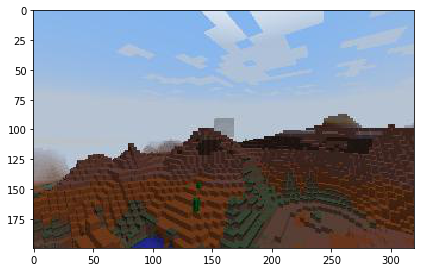

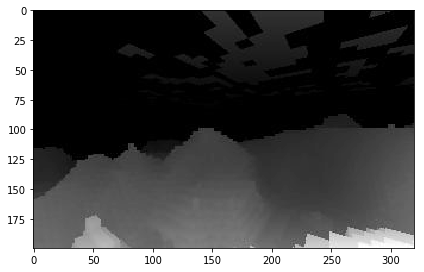

(200, 320, 3)
current batch


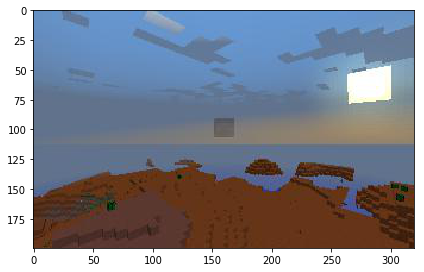

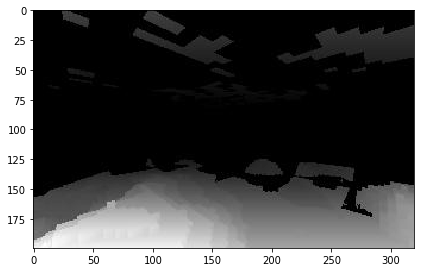

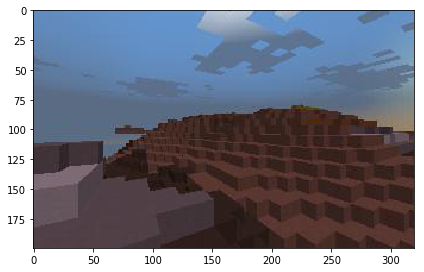

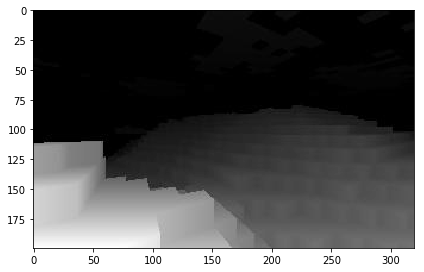

In [13]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation, label = read_and_decode(filename_queue)
print(label)
# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(3):
    
        img, anno, lab = sess.run([image, annotation,label])
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

        io.imshow(anno[0, :, :, 0])
        io.show()
        
        
        io.imshow(img[1, :, :, :])
        io.show()
        
        io.imshow(anno[1, :, :, 0])
        io.show()
    
    coord.request_stop()
    coord.join(threads)